# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Load Data

In [2]:


# Load the processed 'Adj Close' data from the CSV saved in Task 1
try:
    data = pd.read_csv('../data/adj_close.csv', index_col=0, parse_dates=True)
    # Ensure column names are simplified for easier access if they are still tuples from previous runs
    if isinstance(data.columns, pd.MultiIndex):
        new_cols = []
        for col_tuple in data.columns:
            if 'TSLA' in col_tuple:
                new_cols.append('TSLA')
            elif 'BND' in col_tuple:
                new_cols.append('BND')
            elif 'SPY' in col_tuple:
                new_cols.append('SPY')
            else:
                new_cols.append('_'.join(map(str, col_tuple)).replace('UNNAMED: ', '').replace('_LEVEL_2', ''))
        data.columns = new_cols
        data = data[['TSLA', 'BND', 'SPY']]
    print("Data loaded successfully from adj_close.csv!")
    print("Columns in loaded data:", data.columns)
except Exception as e:
    print(f"Error loading data from adj_close.csv: {e}")
    try:
        raw_data = pd.read_csv('../data/financial_data.csv', header=[0, 1], index_col=0, parse_dates=True)
        data = raw_data['Adj Close']
        data.columns = ['BND', 'SPY', 'TSLA']
        print("Successfully re-extracted 'Adj Close' from 'financial_data.csv'.")
    except Exception as e_fallback:
        print(f"Fallback failed: {e_fallback}. Cannot proceed without proper data.")
        exit()


Data loaded successfully from adj_close.csv!
Columns in loaded data: Index(['('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')',
       '('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')',
       '('CLOSE', 'TSLA', 'UNNAMED: 3_LEVEL_2')'],
      dtype='object')


# Calculate Daily Returns

In [ ]:
# --- 1. Calculate Daily Returns ---
# Calculate daily percentage change for all assets
daily_returns = data.pct_change().dropna()
daily_returns.columns = ['BND', 'SPY', 'TSLA']  # Rename columns for consistency

# --- 2. Define Expected Returns ---
tsla_predicted_annual_return = -0.54 # This is a placeholder derived from the visual forecast
tsla_expected_daily_return = (1 + tsla_predicted_annual_return)**(1/252) - 1


# Calculate historical average daily returns (annualized) for BND and SPY
bnd_expected_daily_return = daily_returns['BND'].mean()
spy_expected_daily_return = daily_returns['SPY'].mean()

# Annualize the daily returns for BND and SPY
bnd_annual_return = bnd_expected_daily_return * 252
spy_annual_return = spy_expected_daily_return * 252

expected_returns = np.array([tsla_predicted_annual_return, bnd_annual_return, spy_annual_return])
assets = ['TSLA', 'BND', 'SPY'] # Ensure order matches expected_returns

print("\nExpected Annual Returns (for optimization):")
for i, asset in enumerate(assets):
    print(f"{asset}: {expected_returns[i]:.4f}")


Expected Annual Returns (for optimization):
TSLA: -0.5400
BND: 0.0196
SPY: 0.1448


# Covarianc Matrix

In [ ]:
# --- 3. Covariance Matrix ---
cov_matrix_daily = daily_returns.cov()

# Annualize the covariance matrix
cov_matrix_annual = cov_matrix_daily * 252

print("\nAnnualized Covariance Matrix:")
print(cov_matrix_annual)


Annualized Covariance Matrix:
           BND       SPY      TSLA
BND   0.003016  0.001150  0.001861
SPY   0.001150  0.033272  0.052950
TSLA  0.001861  0.052950  0.350331


# Frontier Simulation


Simulated 50000 portfolios.
Sample of portfolio results:
     Return  Volatility  Sharpe_Ratio
0 -0.060552    0.406360     -0.149010
1 -0.208121    0.125522     -1.658046
2  0.055846    0.301577      0.185180
3 -0.170237    0.128635     -1.323413
4  0.032317    0.289269      0.111718


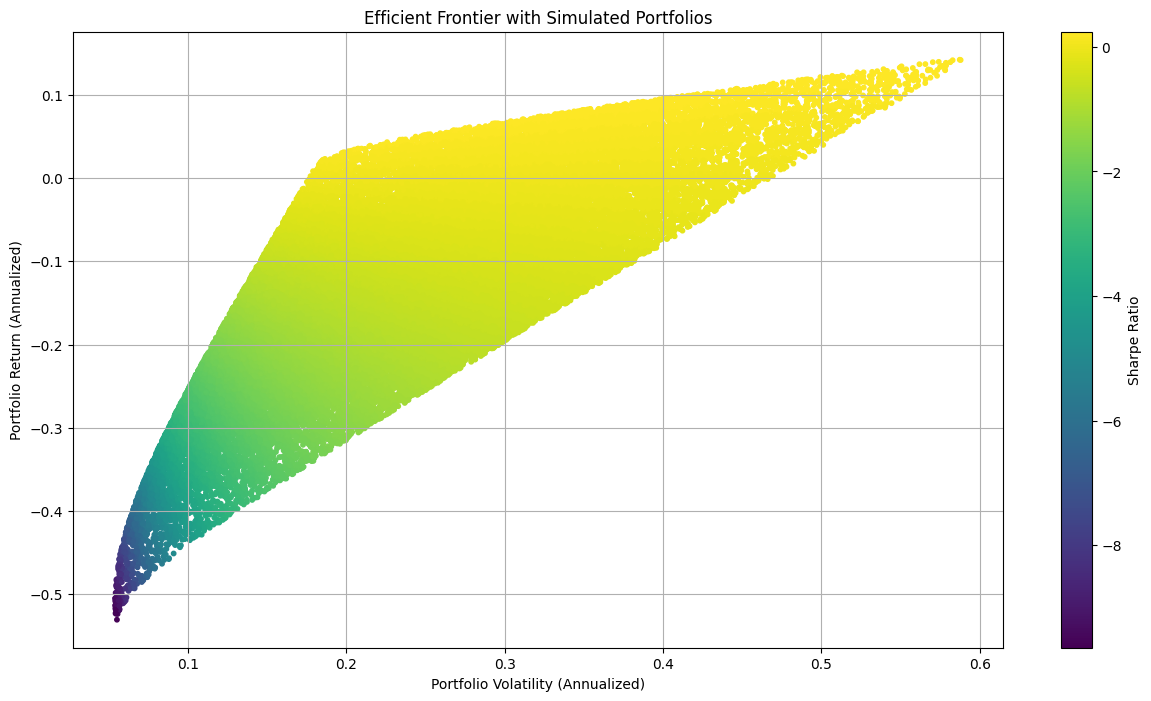

In [ ]:
# --- 4. Efficient Frontier Simulation ---

num_portfolios = 50000 # Number of random portfolios to simulate
results = np.zeros((3, num_portfolios)) # Array to store returns, volatility, and Sharpe Ratio
weights_record = [] # To store the weights for each portfolio

# Loop to generate random portfolios
for i in range(num_portfolios):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights) # Normalize weights to sum to 1
    weights_record.append(weights)

    portfolio_return = np.sum(weights * expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

    # Assuming a risk-free rate of 0 for simplicity (can be adjusted)
    risk_free_rate = 0.0 # As used in Task 1 Sharpe Ratio calculation
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = sharpe_ratio

# Create a DataFrame for results
results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe_Ratio'])

print(f"\nSimulated {num_portfolios} portfolios.")
print("Sample of portfolio results:")
print(results_df.head())

# --- Plot the Efficient Frontier ---
plt.figure(figsize=(15, 8))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe_Ratio'], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier with Simulated Portfolios')
plt.xlabel('Portfolio Volatility (Annualized)')
plt.ylabel('Portfolio Return (Annualized)')
plt.grid(True)
plt.show()